# Lesson 6
Robert Lisy

#### Workplace Scenario
Cypress from New Ventures Department has found a banking client who wants to do a targeted marketing campaign for a specialty investment product to some of its customers. Cypress stresses that the bank only wants to spend the effort on customers who are likely to say yes; last year they used a different company to generate an algorithm and ended up spamming many of their customers with products they didn't want.

- Read in, parse, and pre-process the data. You'll probably have to encode the categorical variables here.
- Perform a brief exploratory analysis. Ideas:
    - Plot numeric variables correlation w/ target (1,0)
- Split data set. Since we will be exploring some hyperparameters before choosing/evaluating the final model, split the data into train/test/validation.
- Compare the performance between a decision tree and a random forest approach by assessing the accuracy of each model on the validation sets.
- Look and compare the feature importances between both the decision tree and the random forest.
- Why do you suppose the random forest importances have a different distribution?
- Finally, assess the performance on the test set.

Summarize your whole assignment. 
Suggestions:

- Start at the top, read your whole assignment from top to bottom. 
- Fill in any missing gaps or intermediate results.
- If you were to make a recommendation to a bank on what modeling method we were going to chose and why, what would you say in a few complete sentences?

In [1]:
# Read in the file...
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

file = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Bank%20Data.csv"

df = pd.read_csv(file)
print(f"Shape: {df.shape}")

# Plotting for confusion matrices...
def plot_cf_matrix(cm):
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
    plt.show();

Shape: (600, 11)


In [2]:
# Inspect
df.head()

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,FEMALE,INNER_CITY,17546.0,NO,1,NO,NO,NO,NO,YES
1,40,MALE,TOWN,30085.1,YES,3,YES,NO,YES,YES,NO
2,51,FEMALE,INNER_CITY,16575.4,YES,0,YES,YES,YES,NO,NO
3,23,FEMALE,TOWN,20375.4,YES,3,NO,NO,YES,NO,NO
4,57,FEMALE,RURAL,50576.3,YES,0,NO,YES,NO,NO,NO


In [3]:
df.dtypes

age              int64
sex             object
region          object
income         float64
married         object
children         int64
car             object
save_act        object
current_act     object
mortgage        object
pep             object
dtype: object

In [4]:
# Convert the categorical columns...
cat_cols = ['sex', 'region', 'married', 'car', 'save_act', 'current_act', 'mortgage']

for c in cat_cols:
    df[c] = df[c].astype('category')

df.dtypes

age               int64
sex            category
region         category
income          float64
married        category
children          int64
car            category
save_act       category
current_act    category
mortgage       category
pep              object
dtype: object

In [5]:
# Let's look at correlation with our target variable

# Convert Pep to integer...
m = {'YES' : 1, 'NO' : 0, 1 : 1, 0 : 0}
df['pep'] = df['pep'].map(m)
df['pep'] = df['pep'].astype('int')
df.dtypes

age               int64
sex            category
region         category
income          float64
married        category
children          int64
car            category
save_act       category
current_act    category
mortgage       category
pep               int64
dtype: object

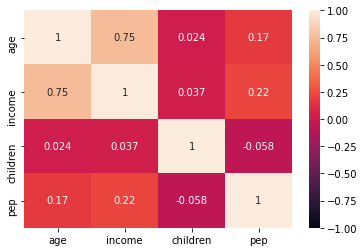

In [6]:
# Looks like income, then age are correlated with opening a PEP.
# also, the fewer children a customer has, the lower their likelihood of opening a PEP
sns.heatmap(df.corr(),
            vmin=-1,
            annot=True);

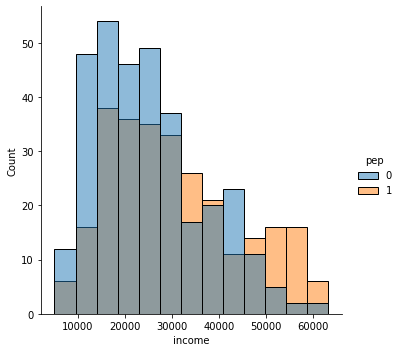

In [7]:
# Look a the distribution of income, colored by PEP
sns.displot(x = df['income'], hue=df['pep']);

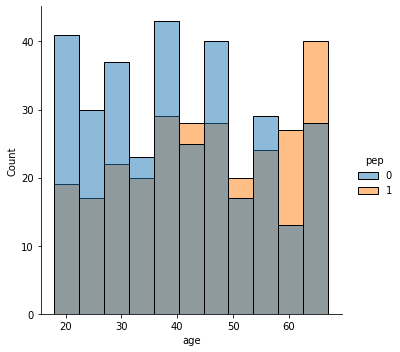

In [8]:
# annnnddd age...
sns.displot(x = df['age'], hue=df['pep']);

# Data Summary

Older, higher income people with more children open PEP accounts.

AAAAREEEEE YOUUUUU REAAADDDYYY TOOOOOOO MODDDDEEELLLL????

In [9]:
df.dtypes

age               int64
sex            category
region         category
income          float64
married        category
children          int64
car            category
save_act       category
current_act    category
mortgage       category
pep               int64
dtype: object

In [10]:
# 60 / 20 / 20 split for train, test, and validation
train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

# split out our data frame into target and attributes..
target = ['pep']
attributes = ['age', 'sex', 'region', 'income', 'married', 'children',
              'car', 'save_act', 'current_act', 'mortgage']

# Split out our data...
X_train = train[attributes]
y_train = train[target]
X_test = test[attributes]
y_test = test[target]
X_validate = validate[attributes]
y_validate = validate[target]

In [11]:
X_train_remap = X_train.copy()
X_test_remap = X_test.copy()

# Columns to label encode...
remap_cols = ['sex', 'region', 'married', 'car', 'save_act', 'current_act', 'mortgage']

# First fit remapping on TRAIN set, apply (transform) both train/test.
for col in remap_cols:
    # Initialize/ re-initialize label encoder for the column
    le = LabelEncoder()
    # FIT the encoder on train set.
    le.fit(X_train[col])
    # Transform both the train and test set.
    X_train_remap[col] = le.transform(X_train[col])
    X_test_remap[col] = le.transform(X_test[col])
    X_validate[col] = le.transform(X_validate[col])
    # we can use this to print the mapping if we need to
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(label_mapping)

{'FEMALE': 0, 'MALE': 1}
{'INNER_CITY': 0, 'RURAL': 1, 'SUBURBAN': 2, 'TOWN': 3}
{'NO': 0, 'YES': 1}
{'NO': 0, 'YES': 1}
{'NO': 0, 'YES': 1}
{'NO': 0, 'YES': 1}
{'NO': 0, 'YES': 1}


/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


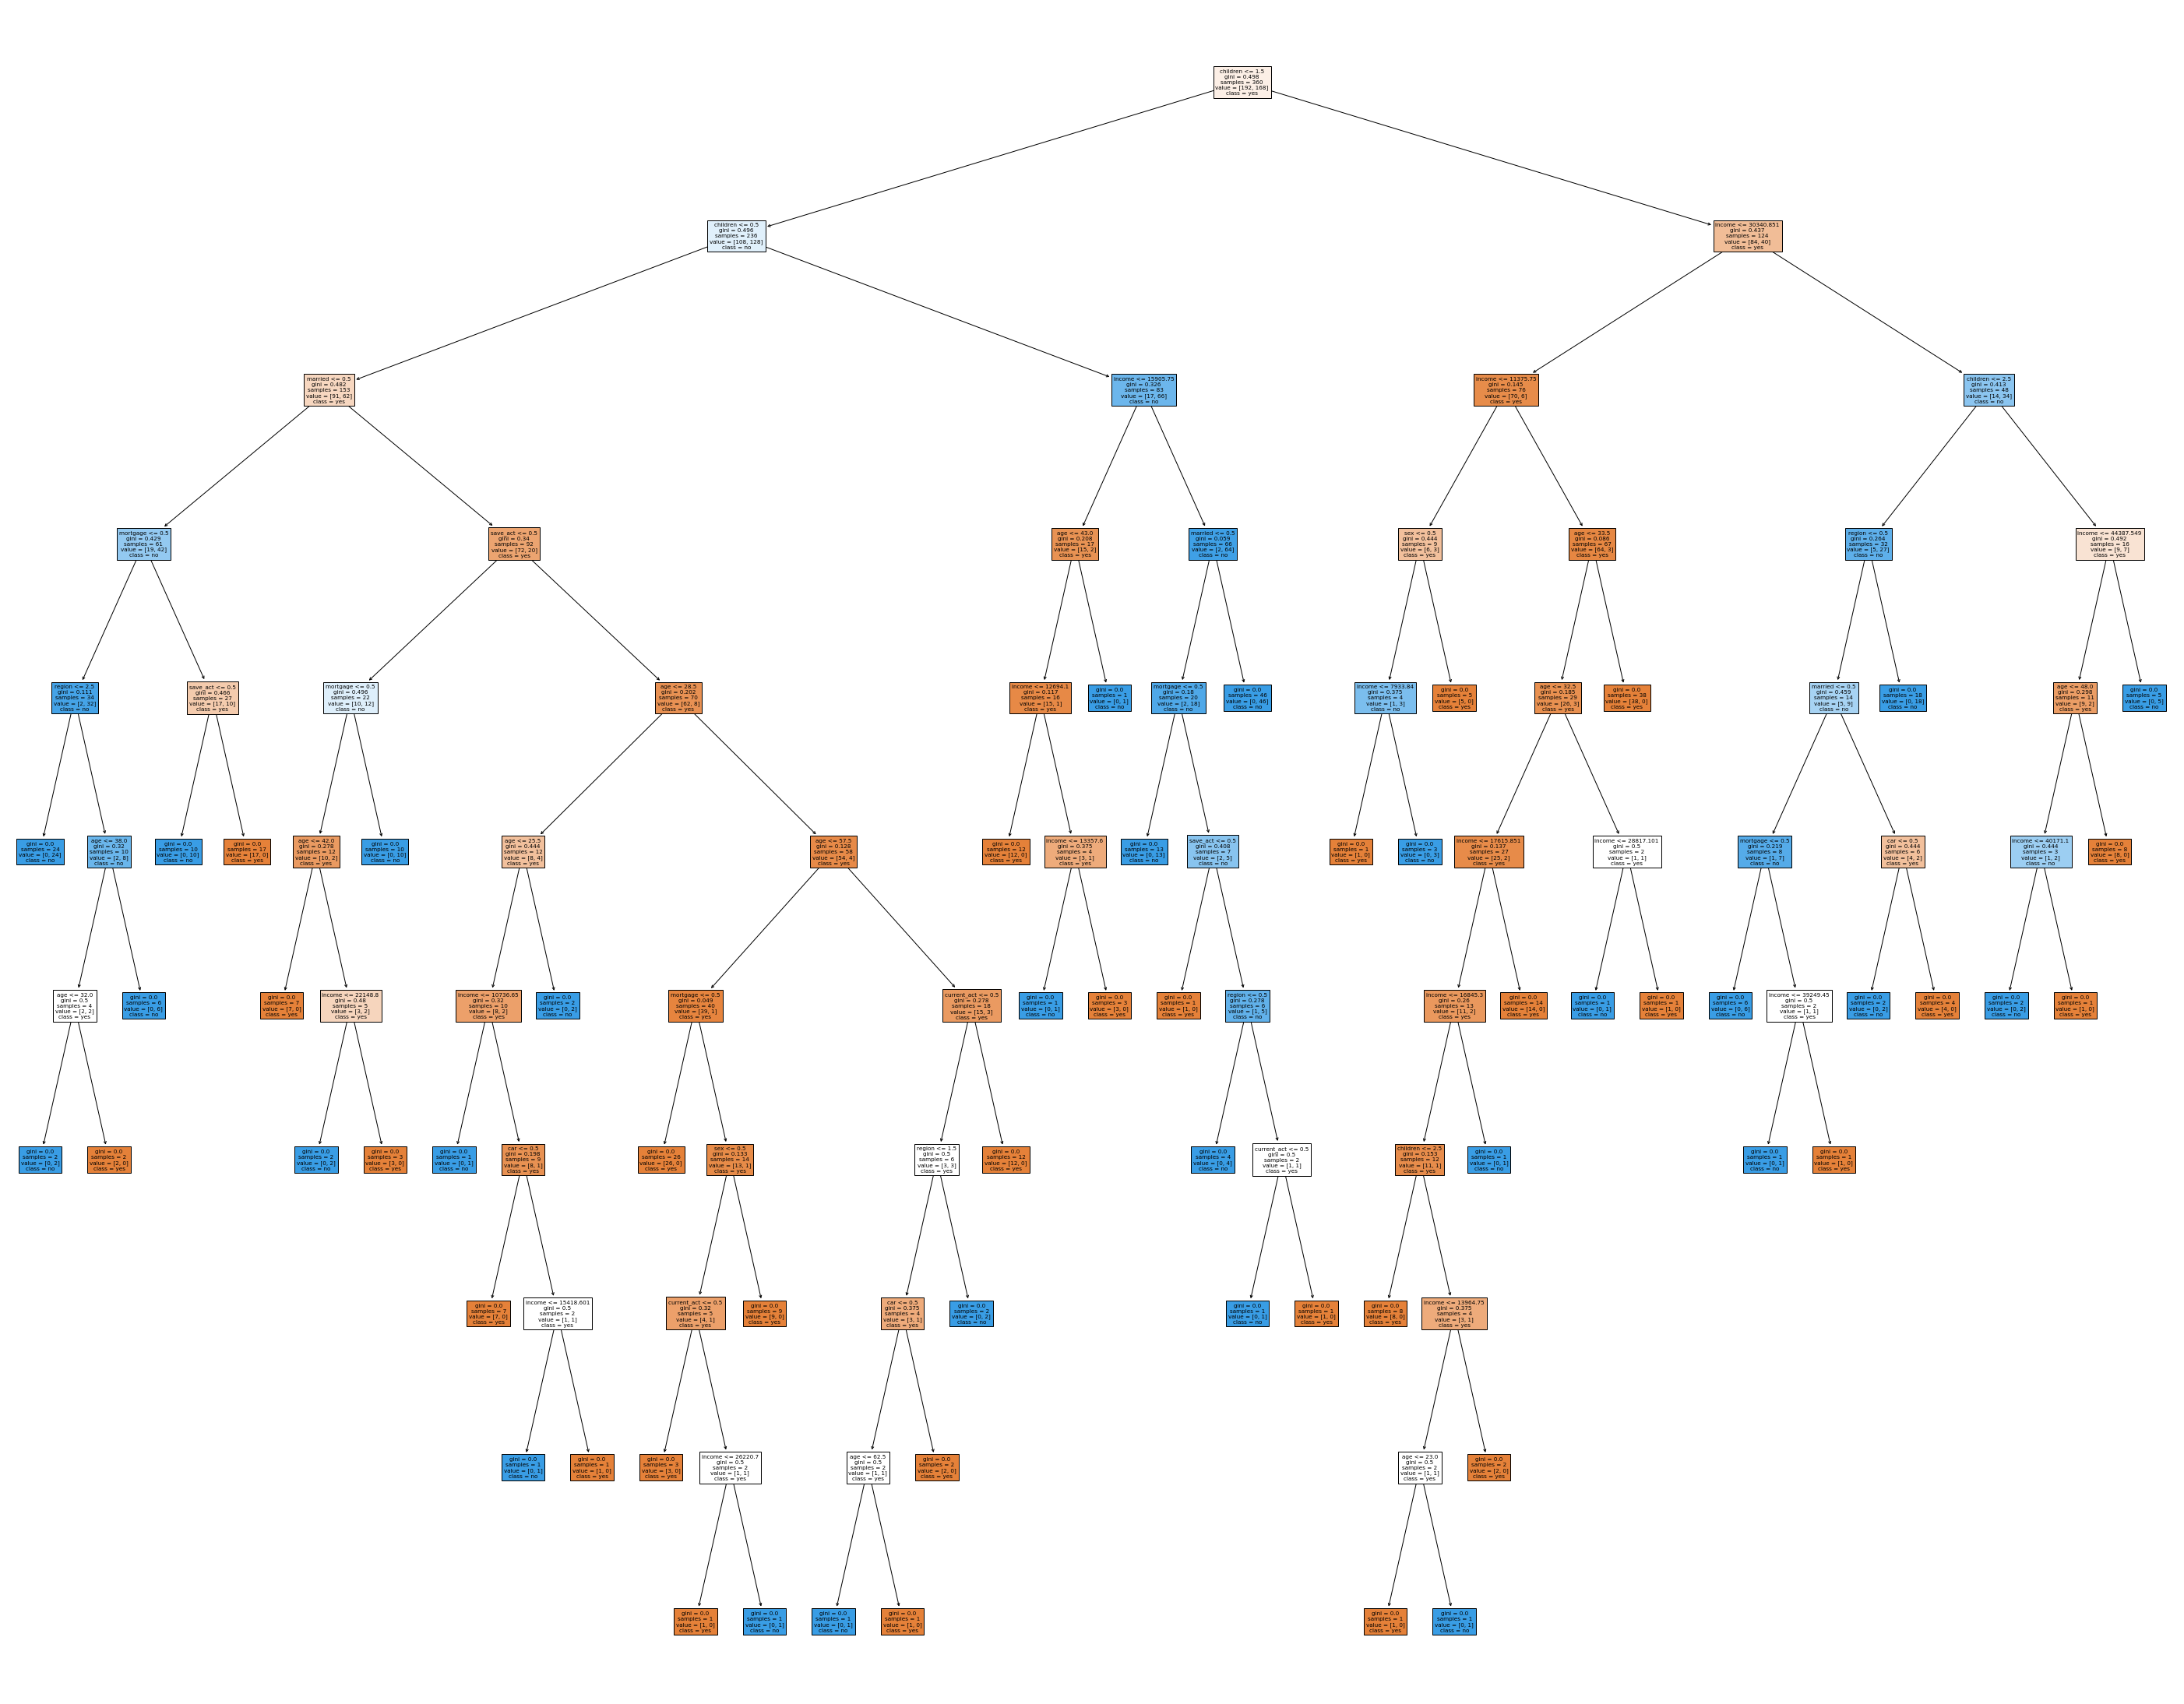

In [12]:
# Decision tree performance
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_remap, y_train)

fig = plt.figure(figsize=(50,40))
_ = tree.plot_tree(clf, 
                   feature_names=attributes,  
                   class_names=['yes', 'no'],
                   filled=True)

fig.savefig("decision_tree.png")

# Make the best decision tree

We've made _a_ decision tree, now let's make the best one...

In [13]:
# Find the best decision tree...
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 31),
    'min_samples_split': range(1, 11),
}

dt = DecisionTreeClassifier()
gscv = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
)
best_decision_tree = gscv.fit(X_train_remap, y_train)

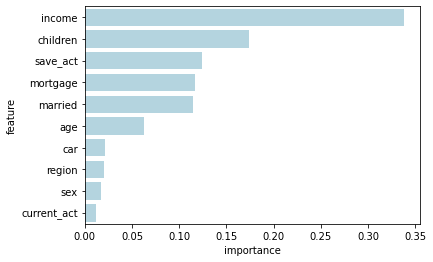

In [14]:
# Show feature importance for the decision tree.
df_var_imp = pd.DataFrame({"feature": X_train_remap.columns, 
                           "importance": best_decision_tree.best_estimator_.feature_importances_})
df_var_imp.sort_values(by = "importance", ascending = False, inplace = True)

ax = sns.barplot(x = "importance", y = "feature", data = df_var_imp.head(10), color = "lightblue")

The best decision tree parameters are {'criterion': 'gini', 'max_depth': 23, 'min_samples_split': 6} 




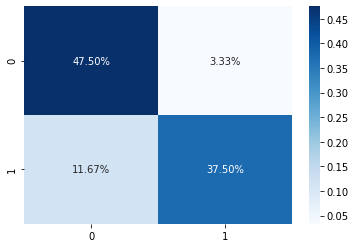

In [15]:
# Evaluate performance of predicted vs actuals....
print(f"The best decision tree parameters are {best_decision_tree.best_params_} \n\n")
y_pred_test = best_decision_tree.predict(X_test_remap)

plot_cf_matrix(confusion_matrix(y_test, y_pred_test))

# Random Forest

We will now create a random forest and compare this to our decision tree. Because we'll be using information contained in the `train` and `test` data sets, we have to have a `validation` data set which we will use to compare the best models against each other at the end of things.

In [16]:
hypers = {"n_estimators": 500, "max_features": "sqrt", "max_depth": 20, "min_samples_leaf": 10}

clf_rf = RandomForestClassifier(random_state = 0, verbose = True, **hypers)
clf_rf.fit(X_train_remap, y_train)

/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished


RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=10,
                       n_estimators=500, random_state=0, verbose=True)

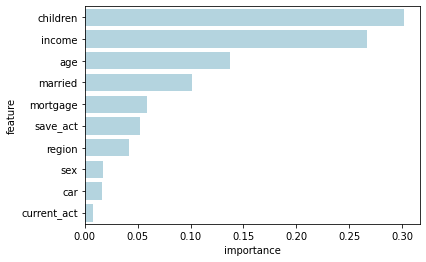

In [17]:
# Show feature importance
df_var_imp = pd.DataFrame({"feature": X_train_remap.columns, 
                           "importance": clf_rf.feature_importances_})
df_var_imp.sort_values(by = "importance", ascending = False, inplace = True)

ax = sns.barplot(x = "importance", y = "feature", data = df_var_imp.head(10), color = "lightblue")

In [18]:
y_hat_train = clf_rf.predict(X_train_remap)
y_hat_test = clf_rf.predict(X_test_remap)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


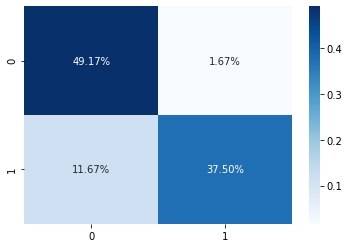

In [19]:
plot_cf_matrix(confusion_matrix(y_test, y_hat_test))

# Model Comparision

We now have 2 models: random forest and a decision tree. We also have a business problem - the bank wants to minimize false positives. Let's comare the model performance on the validation set and make sure that we're not overfitting AND make sure we don't have some form of leakage.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


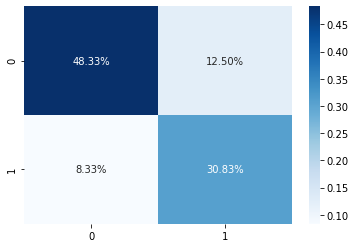

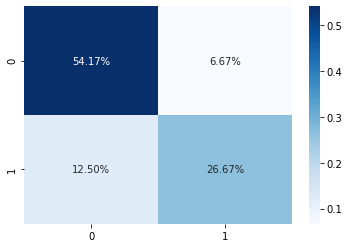

In [20]:
decision_tree_y_validate = best_decision_tree.best_estimator_.predict(X_validate)
random_forest_y_validate = clf_rf.predict(X_validate)

plot_cf_matrix(confusion_matrix(y_validate, decision_tree_y_validate))
plot_cf_matrix(confusion_matrix(y_validate, random_forest_y_validate))

# Summary

To minimize false positives, random forest clearly outperforms a decision tree. Random forests put more weight on the number of children and income than decision trees. This could be because of how the two algorithms split the data - by looking at many subsets of the data, Random Forest may be better at isolating the effect of children seperate from income. Decision trees look at both things at the _same time_, which may lead to a form of multi-colinarity.

The Random Forest sends advertisements out incorrectly to customers in the validation set at about 6.67%, vs the 12.5% for a decision tree. It sounds like these clients want to minimize Type I error.

For the bank, I'd recommend going forward with our Random Forest model. I would also talk to them about their selected metric (minimize false positives), since I actually disagree with their target. Spamming customers who DON'T want a product is usually MUCH LESS impactful than missing out. Very few customers receive an advertisement which inspires them to leave a business relationship. Missing out on a customer who may buy your product is usually the much more important error, especially given how cheaply we can market to customers these days (email, social media, etc.).